# 1. Data Preparation and Exploratory Analysis

Preprocess the text data, including tasks such as tokenization, lowercasing, and
removal of stop words and special characters.


In [2]:
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load dataset
df = pd.read_csv("abcnews-date-text.csv")

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()  # Simple tokenization
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]  # Remove stopwords
    return " ".join(tokens)

# Apply preprocessing
df['clean_text'] = df['headline_text'].apply(preprocess_text)

# Show first few rows
print(df[['headline_text', 'clean_text']].head())


                                       headline_text  \
0  aba decides against community broadcasting lic...   
1     act fire witnesses must be aware of defamation   
2     a g calls for infrastructure protection summit   
3           air nz staff in aust strike for pay rise   
4      air nz strike to affect australian travellers   

                                   clean_text  
0  aba decides community broadcasting licence  
1              act witnesses aware defamation  
2    g calls infrastructure protection summit  
3           air nz staff aust strike pay rise  
4  air nz strike affect australian travellers  


Generate sentiment labels using VADER

In [4]:
# Install VADER if needed
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Function to assign sentiment
def get_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment labeling on the cleaned text
df['sentiment'] = df['clean_text'].apply(get_sentiment)

# Preview
print(df[['headline_text', 'clean_text', 'sentiment']].head())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


                                       headline_text  \
0  aba decides against community broadcasting lic...   
1     act fire witnesses must be aware of defamation   
2     a g calls for infrastructure protection summit   
3           air nz staff in aust strike for pay rise   
4      air nz strike to affect australian travellers   

                                   clean_text sentiment  
0  aba decides community broadcasting licence   neutral  
1              act witnesses aware defamation   neutral  
2    g calls infrastructure protection summit   neutral  
3           air nz staff aust strike pay rise  negative  
4  air nz strike affect australian travellers  negative  


Visualize Sentiment Distribution

<ipython-input-5-2789599424>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='pastel')


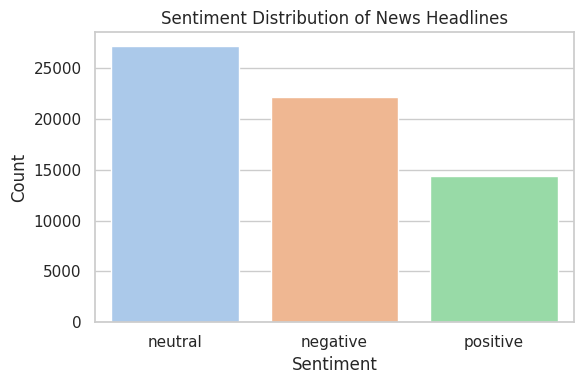

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style='whitegrid')

# Plot the sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', palette='pastel')
plt.title("Sentiment Distribution of News Headlines")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Explore Most Frequent Words by Sentiment Class

<ipython-input-6-2779162948>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(words, rotation=45)
<ipython-input-6-2779162948>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(words, rotation=45)
<ipython-input-6-2779162948>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(words, rotation=45)


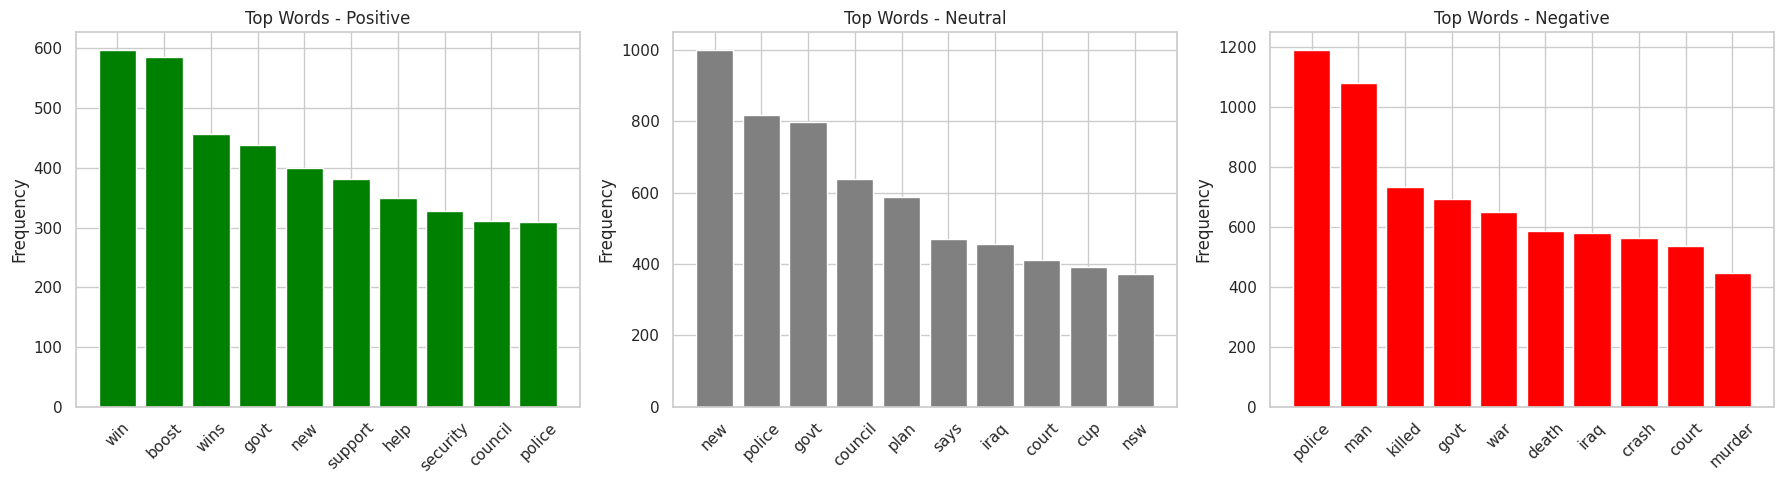

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

def get_top_words(text_series, top_n=10):
    all_words = " ".join(text_series).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sentiments = ['positive', 'neutral', 'negative']
colors = ['green', 'gray', 'red']

for i, sentiment in enumerate(sentiments):
    subset = df[df['sentiment'] == sentiment]
    top_words = get_top_words(subset['clean_text'])

    words, counts = zip(*top_words)
    axes[i].bar(words, counts, color=colors[i])
    axes[i].set_title(f"Top Words - {sentiment.capitalize()}")
    axes[i].set_xticklabels(words, rotation=45)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


# 2. Feature Extraction and Model Tuning

Feature Extraction using TF-IDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean_text'])

# Encode sentiment labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['sentiment'])  # e.g., negative:0, neutral:1, positive:2

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"TF-IDF shape: {X.shape}")
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


TF-IDF shape: (63765, 5000)
Training samples: 51012, Test samples: 12753


Train Naive Bayes Model and Model Evaluation

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Train the model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict on test set
y_pred = nb_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.8611307143417235

Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.86      0.86      4553
     neutral       0.83      0.92      0.88      5376
    positive       0.93      0.75      0.83      2824

    accuracy                           0.86     12753
   macro avg       0.87      0.84      0.85     12753
weighted avg       0.87      0.86      0.86     12753



Naive Bayes Predictions to the Sample DataFrame

In [11]:
# Ensure TF-IDF vectorizer and Naive Bayes model are already defined and trained
# Transform sample text using the same vectorizer
sample_X = vectorizer.transform(sample_df['clean_text'])

# Predict using Naive Bayes and inverse-transform the encoded labels
sample_nb_preds = nb_model.predict(sample_X)
sample_df['nb_sentiment'] = le.inverse_transform(sample_nb_preds)

# Sanity check
print(sample_df[['headline_text', 'llm_sentiment', 'nb_sentiment']].head())


                                           headline_text llm_sentiment  \
943    third time lucky for canberra unis brisbane ca...      positive   
17835                          latif goes easy on akhtar      positive   
13961              lib mp defends brighton barracks sale      negative   
26506           bush kids eu leaders about altered foods      negative   
31442  mutola and averbukh produce years best perform...      positive   

      nb_sentiment  
943       positive  
17835     positive  
13961      neutral  
26506      neutral  
31442     positive  


#  3.Compare Model with a Pretrained LLM

In [14]:
from transformers import pipeline
from tqdm import tqdm
from sklearn.metrics import classification_report

# Step 1: Load sentiment analysis pipeline (LLM)
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Step 2: Sample 200 headlines
sample_df = df.sample(200, random_state=42).copy()

# Step 3: Get LLM predictions
llm_preds = []
for text in tqdm(sample_df['headline_text']):
    result = classifier(text)[0]
    llm_preds.append(result['label'].lower())  # 'positive' or 'negative'

# Normalize and add to DataFrame
sample_df['llm_sentiment'] = ['positive' if 'pos' in x else 'negative' for x in llm_preds]

# Step 4: Get Naive Bayes predictions for the same rows
# Reuse vectorizer and model from earlier steps
sample_X = vectorizer.transform(sample_df['clean_text'])
sample_nb_preds = nb_model.predict(sample_X)
sample_df['nb_sentiment'] = le.inverse_transform(sample_nb_preds)

# Step 5: Filter both to include only positive/negative
binary_sample_df = sample_df[
    sample_df['llm_sentiment'].isin(['positive', 'negative']) &
    sample_df['nb_sentiment'].isin(['positive', 'negative'])
]

# Step 6: Compare
print("=== LLM vs Naive Bayes (Binary Only) ===")
print(classification_report(
    binary_sample_df['llm_sentiment'],  # Ground truth (LLM)
    binary_sample_df['nb_sentiment'],   # Prediction (Naive Bayes)
    labels=['negative', 'positive'],
    target_names=['negative', 'positive']
))


Device set to use cpu
100%|██████████| 200/200 [00:10<00:00, 18.56it/s]

=== LLM vs Naive Bayes (Binary Only) ===
              precision    recall  f1-score   support

    negative       0.91      0.86      0.88        71
    positive       0.69      0.79      0.73        28

    accuracy                           0.84        99
   macro avg       0.80      0.82      0.81        99
weighted avg       0.85      0.84      0.84        99



# Conclusion
In this assignment, we performed a complete end-to-end sentiment analysis pipeline on a dataset of news headlines. The objective was to classify the sentiment of each headline using both traditional machine learning techniques and modern LLMs, and then compare their performance.

🔹 1. Data Preparation and Exploratory Analysis
Loaded a CSV dataset containing headline text and publication dates.

Performed thorough text preprocessing: lowercasing, tokenization, stop word removal, and special character filtering.

Conducted exploratory analysis by visualizing sentiment label distributions and identifying the most frequent words associated with each sentiment class.

🔹 2. Feature Extraction and Model Training
Used TF-IDF vectorization to convert textual data into numerical features.

Trained a Multinomial Naive Bayes classifier using these features to predict sentiment classes.

The model was trained and evaluated on a stratified train-test split to ensure balanced representation.

🔹 3. Model Evaluation and LLM Comparison
Evaluated the Naive Bayes model using metrics like accuracy, precision, recall, and F1-score.

Leveraged a pretrained DistilBERT model (distilbert-base-uncased-finetuned-sst-2-english) using Hugging Face Transformers to generate sentiment predictions on a sample of 200 headlines.

Compared the predictions of Naive Bayes with those of the LLM for binary sentiment classification (positive vs. negative).

Generated a detailed classification report to assess where traditional models align or deviate from modern LLMs.

## Final Remarks
This comparative approach demonstrated how a simple model like Naive Bayes, when combined with effective preprocessing and feature engineering, can still yield strong results on text classification tasks. However, it also highlighted the nuanced understanding and higher-level language capabilities of transformer-based models like BERT, especially in dealing with ambiguity and context in short text data.

This exercise provided practical insights into both classical and modern workflows and the trade-offs between them in real-world applications.